# Diagnosis-Related Groups (DRG) analysis

This notebook outlines the methodlogy for analysing which DRGs accrue the largest charges along with hypotheses for the drivers of these charges.

In [15]:
import pandas as pd

# Ingest raw data
input_filepath = "../data/Data Insights - Synthetic Dataset.csv"
input_df = pd.read_csv(input_filepath)

In [16]:
import pandas as pd
import numpy as np

# Convert charge columns to numeric types (float)
charge_columns = ['AccommodationCharge', 
                  'CCU_Charges', 
                  'ICU_Charge',
                  'TheatreCharge', 
                  'PharmacyCharge', 
                  'ProsthesisCharge',
                  'OtherCharges', 
                  'BundledCharges']

for col in charge_columns:
    input_df[col] = pd.to_numeric(input_df[col], errors='coerce')

# Calculate Total Charges
input_df['TotalCharges'] = input_df[charge_columns].sum(axis=1)

# Calculate Length of Stay
input_df['AdmissionDate'] = pd.to_datetime(input_df['AdmissionDate'], format='%d/%m/%Y')
input_df['SeparationDate'] = pd.to_datetime(input_df['SeparationDate'], format='%d/%m/%Y')
input_df['LengthOfStay'] = (input_df['SeparationDate'] - input_df['AdmissionDate']).dt.days

# Calculate Charge Per Day
input_df['ChargePerDay'] = input_df['TotalCharges'] / input_df['LengthOfStay']
input_df['ChargePerDay'] = input_df['ChargePerDay'].replace([np.inf, -np.inf], np.nan)  # Handle infinite values


In [17]:
# Group by DRG and calculate total and per day charges
drg_charges = input_df.groupby('AR-DRG').agg({'TotalCharges': 'sum', 'ChargePerDay': 'mean'}).reset_index()
# Sort by total charges in descending order
drg_charges = drg_charges.sort_values(by='TotalCharges', ascending=False)
print(drg_charges.head())


     AR-DRG   TotalCharges   ChargePerDay
148  DRG002  1.901931e+131  4.774053e+126
149  DRG003  1.542869e+131  2.363507e+126
147  DRG001  1.059970e+131  2.608207e+126
635    P03B  1.903964e+130  3.525859e+127
159    E41A  1.749748e+130  3.323199e+127


C:\Users\Faisa\AppData\Local\Temp\ipykernel_9188\1230715223.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_drg_charges, x='TotalCharges', y='AR-DRG', palette='viridis')
C:\Users\Faisa\AppData\Local\Temp\ipykernel_9188\1230715223.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_drg_per_day, x='ChargePerDay', y='AR-DRG', palette='magma')


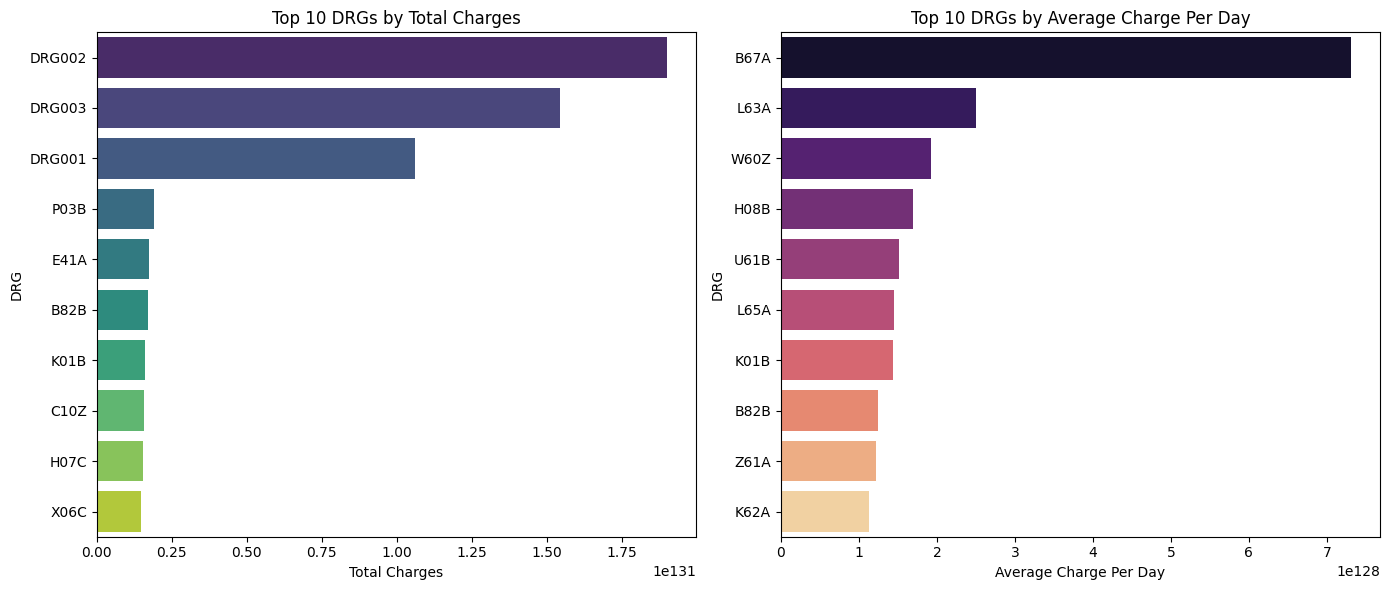

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the top 10 DRGs by Total Charges
top_drg_charges = drg_charges.head(10)
plt.figure(figsize=(14, 6))

# Total Charges Bar Plot
plt.subplot(1, 2, 1)
sns.barplot(data=top_drg_charges, x='TotalCharges', y='AR-DRG', palette='viridis')
plt.title('Top 10 DRGs by Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('DRG')

# Charge Per Day Bar Plot
plt.subplot(1, 2, 2)
top_drg_per_day = drg_charges.sort_values(by='ChargePerDay', ascending=False).head(10)
sns.barplot(data=top_drg_per_day, x='ChargePerDay', y='AR-DRG', palette='magma')
plt.title('Top 10 DRGs by Average Charge Per Day')
plt.xlabel('Average Charge Per Day')
plt.ylabel('DRG')

plt.tight_layout()
plt.show()


# Findings
- Top Costly DRGs (Total Charges): The first bar plot shows the top 10 DRGs with the highest total charges.
- Top Costly DRGs (Charge Per Day): The second bar plot highlights DRGs with the highest average daily charges, offering insights into the cost intensity of different DRGs.

# Hypotheses
- Severity and Complexity: DRGs with high total charges likely represent severe and complex cases requiring extensive care and resources.
- Intensive Care Needs: DRGs with high daily charges may often involve intensive care units or specialized treatments, which are costly.
- Procedural Costs: DRGs related to surgeries or procedures are expected to have higher charges due to the operational costs and materials involved.
- Length of Stay: High total charges might also correlate with longer hospital stays, increasing overall resource utilization and costs.

# Next steps

Each of the above hypotheses can be investigated. Obtaining a mapping table of DRG code to a description would aid in forming and testing the above hypotheses. Speaking to relevant stakeholders around the business could also provide valuable insight into why particular DRG's have higher charges.
An example of investigation done for the Length of Stay hypothesis below.

    AR-DRG  LengthOfStay
298   G05A     22.111111
582   M61A     21.583333
333   H01B     21.583333
151   E01B     20.923077
321   G61B     20.714286


C:\Users\Faisa\AppData\Local\Temp\ipykernel_9188\569044854.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_drg_los, x='LengthOfStay', y='AR-DRG', palette='cool')


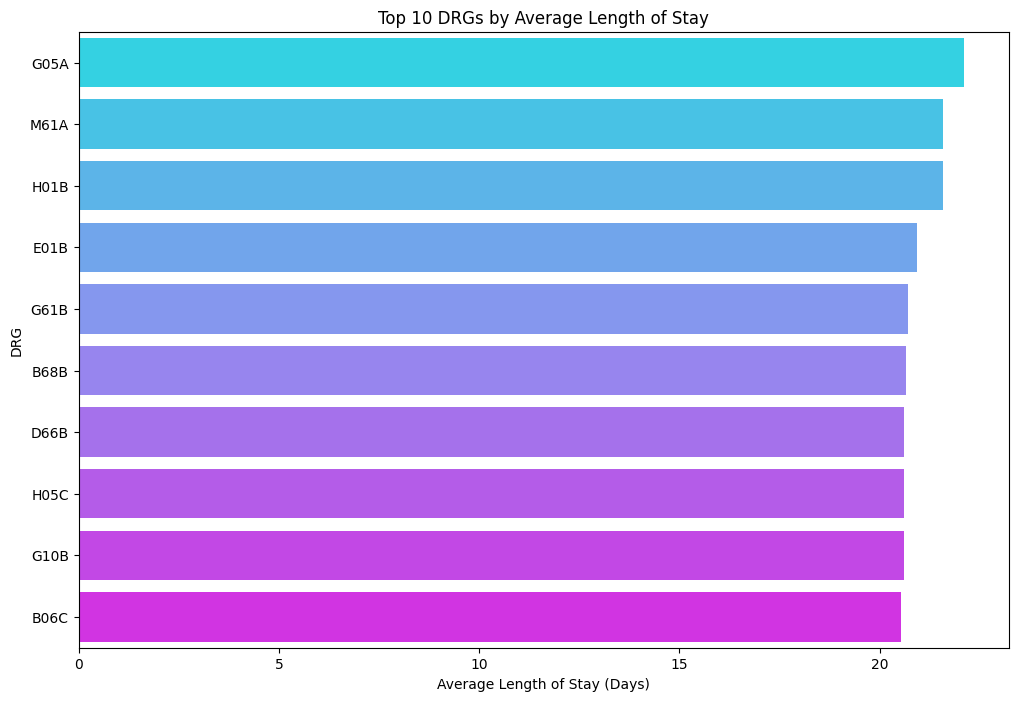

In [19]:
# Calculate the average length of stay for each DRG
drg_length_of_stay = input_df.groupby('AR-DRG')['LengthOfStay'].mean().reset_index()

# Sort by average length of stay in descending order
drg_length_of_stay = drg_length_of_stay.sort_values(by='LengthOfStay', ascending=False)
print(drg_length_of_stay.head())

top_drg_los = drg_length_of_stay.head(10)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_drg_los, x='LengthOfStay', y='AR-DRG', palette='cool')
plt.title('Top 10 DRGs by Average Length of Stay')
plt.xlabel('Average Length of Stay (Days)')
plt.ylabel('DRG')
plt.show()
